# NBA BasketballReference Draft Scraper + Analysis & Visualizations

## Project Overview:

### Objective:

I wish to collect the career stats of top picks from the past 20 NBA drafts. I will compare numerical stats among players in drafts using graphs and visualization techniques and will also explore interesting relationships among the scraped data with different visualization techniques.

### Tasks:

1. From www.basketball-reference.com/draft, scrape the rookie stats of the top 10 overall picks of last 20 NBA drafts (2001 - 2020)
2. Scrape data into a single Pandas MultiIndexDataFrame with outer index of draft year and inner index of pick number
3. Run DataFrame manipulations and various visualization techniques to gain insight into questions regarding drafting teams, picks, and player stats.

*** In this analysis, "Drafting teams" includes teams that trade for a pick. Drafting teams are teams that a rookie plays for for the entire season. Therefore, teams that trade or receive picks midway through the season will not be counted in this analysis.

## Imports

In [24]:
import numpy as np
from scipy import stats

import pandas as pd

import requests
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

%matplotlib inline

## Scraper Code and Processing

In [2]:
# Initialize dictionary and lists to be used in scraper

player_data = {'team_id':[],'pos':[],'player':[],'mp_per_g':[],'efg_pct':[],
               'pts_per_g':[],'trb_per_g':[],'ast_per_g':[],'ws':[],'bpm':[]}   # Columns for DataFrame

index_array = [[],[]]  # Used for MultiIndex

positions = ["Point Guard","Shooting Guard","Small Forward","Power Forward","Center"] # Used to scrape Positions

In [3]:
def get_doc(url):   # return BeautifulSoup parsed document
    response = requests.get(url)
    response.close()
    soup = BeautifulSoup(response.text,'html.parser')
    return soup


def scrape_draft(doc,year): # Scrape players' data for single draft
    tr_tags = doc.findAll('tr')
    for pick in range(2,12,1):
        get_advanced_stats(tr_tags, pick)  # Scrape certain stats from main draft page
        player_url = "https://www.basketball-reference.com" + tr_tags[pick].find('td',{'data-stat':'player'}).a['href']
        get_player_data(get_doc(player_url))  # Scrape stats from individual player pages
        index_array[0].append(year)
        index_array[1].append(pick - 1)
        
        
def get_advanced_stats(tags, pick):  # Scrape player's career advanced stats from the draft page
    for key in ['ws','bpm','player']:
        field = tags[pick].find('td',{'data-stat': key})
        if field is not None:
            player_data[key].append(field.text)
        else:
            player_data[key].append(np.NaN)

    
def get_player_data(doc):  # Scraper player's rookie season data off of individual page
    rookie_stats = doc.findAll('tr',{'class':'full_table'})[0]
    for key in player_data:
        if key not in ['pos','ws','bpm','player']:
            field = rookie_stats.find('td',{'data-stat': key})
            if field is not None:
                player_data[key].append(field.text) # Append values to dictionary
            else:
                player_data[key].append(np.NaN)   # Appends missing values dictionary if no data to scrape
    get_player_pos(doc)
    
        
def get_player_pos(doc):  # Scrape player positions
    test_sections = [doc.findAll('p')[i].text.strip() for i in range(1,5,1)]  # Possible lines with position titles
    test_string = ""
    for section in test_sections:
        test_string += section  
    pos = [pos for pos in positions if pos in test_string]  
    player_data['pos'].append(pos) # Appends list of positions on website to dictionary
    
    
def draft_scraper(start_year,end_year):   # Entire web scraper function
    for year in range(start_year, end_year + 1, 1):  # Iterates through all draft years
        draft_url = 'https://www.basketball-reference.com/draft/NBA_' + str(year) + '.html'
        scrape_draft(get_doc(draft_url),year)
 
    # Form MultiIndex
    index_tuples = list(zip(*index_array))   
    index = pd.MultiIndex.from_tuples(index_tuples, names=["year", "pick"])  # Create a Pandas MultiIndex

    return pd.DataFrame(player_data,index=index)  # Returns DataFrame version of player_data dictionary

### Scrape Data into DataFrame

In [4]:
draft_data = draft_scraper(2001,2020)

In [5]:
draft_data.head() # Check the head of the DataFrame

team_id                              pos            player mp_per_g  \
year pick                                                                       
2001 1        WAS          [Power Forward, Center]       Kwame Brown     14.3   
     2        CHI          [Power Forward, Center]    Tyson Chandler     19.6   
     3        MEM          [Power Forward, Center]         Pau Gasol     36.7   
     4        CHI          [Power Forward, Center]        Eddy Curry     16.0   
     5        GSW  [Shooting Guard, Small Forward]  Jason Richardson     32.9   

          efg_pct pts_per_g trb_per_g ast_per_g     ws   bpm  
year pick                                                     
2001 1       .387       4.5       3.5       0.8   20.8  -2.4  
     2       .497       6.1       4.8       0.8  102.1   0.1  
     3       .518      17.6       8.9       2.7  144.1   3.6  
     4       .501       6.7       3.8       0.3   21.7  -2.4  
     5       .463      14.4       4.3       3.0   59.1   1.2

### Data Cleaning / Processing

In [6]:
#Convert 'numeric' objects into numeric types

player_data = {'team_id':[],'pos':[],'player':[],'mp_per_g':[],'efg_pct':[],
               'pts_per_g':[],'trb_per_g':[],'ast_per_g':[],'ws':[],'bpm':[]}  #For use in following processing

draft_data.replace('',np.NaN,inplace=True)
for key in player_data:
    if key not in ['team_id','pos','player','g']:
        draft_data[key] = draft_data[key].astype(float)

In [7]:
#New Positions: guard, guard/forward, forward, forward/center, center

def parse_pos(row):  #Function to parse scraped positions into 1 position
    if len(row) == 1:
        if row[0] == 'Point Guard' or row[0] == 'Shooting Guard':
            return 'Guard'
        elif row[0] == 'Small Forward' or row[0] == 'Power Forward':
            return 'Forward'
        elif row[0] == 'Center':
            return 'Center'
    elif row == ['Power Forward','Center']:
        return 'Forward/Center'
    elif row == ['Small Forward','Power Forward']:
        return 'Forward'
    elif row == ['Point Guard','Shooting Guard']:
        return 'Guard'
    elif row == ['Shooting Guard','Small Forward']:
        return 'Guard/Forward'
    elif len(row) == 3 and row[0] == 'Point Guard':
        return 'Guard'
    else:
        return 'Forward'

draft_data['pos'] = draft_data['pos'].apply(lambda x: parse_pos(x))   #"Resets" row to single position instead of list of positions

In [8]:
# Replace TOT with Multiple (For players with multiple teams their rookie season)

draft_data.replace('TOT','Multiple',inplace=True)

In [9]:
draft_data

team_id             pos            player  mp_per_g  efg_pct  \
year pick                                                                
2001 1        WAS  Forward/Center       Kwame Brown      14.3    0.387   
     2        CHI  Forward/Center    Tyson Chandler      19.6    0.497   
     3        MEM  Forward/Center         Pau Gasol      36.7    0.518   
     4        CHI  Forward/Center        Eddy Curry      16.0    0.501   
     5        GSW   Guard/Forward  Jason Richardson      32.9    0.463   
...           ...             ...               ...       ...      ...   
2020 6        ATL          Center    Onyeka Okongwu      12.0    0.644   
     7        DET           Guard     Killian Hayes      25.8    0.403   
     8        NYK         Forward        Obi Toppin      11.0    0.560   
     9        WAS         Forward       Deni Avdija      23.3    0.502   
     10       PHO         Forward       Jalen Smith       5.8    0.480   

           pts_per_g  trb_per_g  ast_per_g     ws  bpm  
year pick                                               
2001 1           4.5        3.5        0.8   20.8 -2.4  
     2           6.1        4.8        0.8  102.1  0.1  
     3          17.6        8.9        2.7  144.1  3.6  
     4           6.7        3.8        0.3   21.7 -2.4  
     5          14.4        4.3        3.0   59.1  1.2  
...              ...        ...        ...    ...  ...  
2020 6           4.6        3.3        0.4    1.9 -1.3  
     7           6.8        2.7        5.3   -1.1 -7.3  
     8           4.1        2.2        0.5    1.5 -1.0  
     9           6.3        4.9        1.2    1.2 -3.9  
     10          2.0        1.4        0.1    0.1 -6.2  

[200 rows x 10 columns]

## Analysis Questions (For Selected 2001 - 2020 NBA Drafts):

The select questions are addressed below in sequential fashion.

### Analysis 1: Which teams had the most top-10 picks play for them their entire rookie season? Top-5 picks?

In [10]:
most_top10_picks = draft_data.team_id.value_counts().sort_values(ascending=False).head(6)

most_top10_picks

CHI    13
MIN    12
CLE    11
GSW     9
SAC     9
DET     8
Name: team_id, dtype: int64

In [11]:
reset = draft_data.reset_index()
most_top5_picks = reset[reset.pick < 6].team_id.value_counts().sort_values(ascending=False).head(6)

most_top5_picks

MIN    8
CLE    7
CHI    7
MEM    6
PHI    5
ATL    5
Name: team_id, dtype: int64

### Analysis 2: Of the top 5 teams with the most top-10 picks play for them their rookie season, which typically chose the rookies with the most career win shares?

In [12]:
top_pick_teams = most_top10_picks.index.tolist()
top_team_ws = draft_data.groupby('team_id').median().ws[top_pick_teams].sort_values(ascending=True)

top_team_ws

team_id
CLE     5.4
DET     9.3
SAC    13.2
MIN    16.5
CHI    21.7
GSW    26.2
Name: ws, dtype: float64

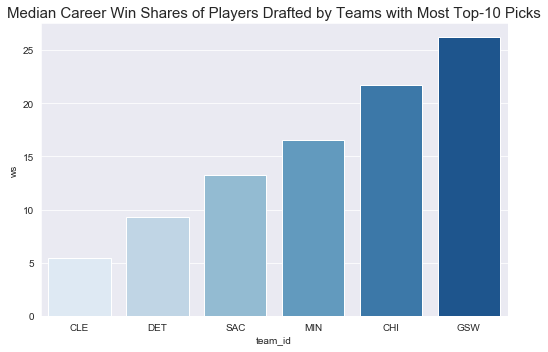

In [25]:
plt.figure(figsize=(8,5))
sns.barplot(x=top_team_ws.index,y=top_team_ws.values,palette='Blues')

plt.title('Median Career Win Shares of Players Drafted by Teams with Most Top-10 Picks',fontdict={'fontsize':15})
plt.ylabel('ws')

plt.tight_layout()

plt.savefig('barplot.png')

### Analysis 3: Have guards had increasing 3PT% in years closer to 2020 than 2001 due to the transition to a distance shooting era?

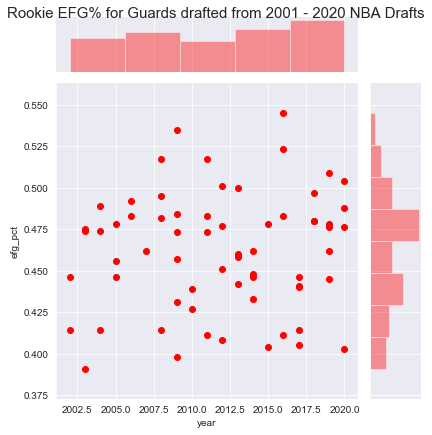

In [26]:
guards = draft_data[draft_data.pos == 'Guard'].reset_index()
guards

plot = sns.jointplot(x='year',y='efg_pct',data=guards,kind='scatter',color='red')
plot.fig.suptitle('Rookie EFG% for Guards drafted from 2001 - 2020 NBA Drafts', x=0.5, y=1, fontsize=15)
plt.tight_layout()


plt.savefig('jointplot.png')

### Analysis 4: Can we visualize clear groupings by position based on players' points, assists, and rebounding averages?

In [15]:
# Let us regroup the positions into 3 categories: Guards, Wings, Big-Men 
# First, we need to see the best way to group these categories:

draft_data['pos'].value_counts()

Guard             65
Forward           52
Forward/Center    39
Center            29
Guard/Forward     15
Name: pos, dtype: int64

In [27]:
"""
Let's map:
    Guard --> Guards
    Guard/Forward , Forward --> Wings
    Forward/Center , Center --> Big-Men
"""

temp = draft_data

temp['new_pos'] = temp.pos.map({'Guard':'Guard','Guard/Forward':'Wing','Forward':'Wing',
                                'Forward/Center':'Big Man','Center':'Big Man'})

#Graph a 3D plot
import plotly.express as pex

plot = pex.scatter_3d(data_frame = temp,x='pts_per_g',y='ast_per_g',z='trb_per_g',color='new_pos')
plot.show()

In [20]:
plot.write_html("3dscatter.html")

##### Let's explore this further ... using Linear Discriminant Analysis with all numeric data as our input and  new_pos as our class label.

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda

X = temp.reset_index().drop(['year','pick','team_id','pos','player','new_pos',
                             'efg_pct','mp_per_g','bpm','ws'],axis=1)   #LDA with PPG, RPG, APG as only input factors
y = temp.new_pos.reset_index().drop(['year','pick',],axis=1).new_pos

lda_model = lda(n_components=2)
newX = lda_model.fit_transform(X.values,y)

In [22]:
lda_model.explained_variance_ratio_

array([0.96226059, 0.03773941])

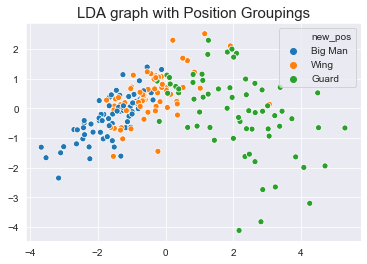

In [30]:
plt.title('LDA graph with Position Groupings',fontdict={'fontsize':15})
sns.scatterplot(x=newX[:,0],y=newX[:,1],hue=y)
plt.savefig('ldascatter.png')

### Analysis 5: Is there a clear relationship between career box score plus minus or win shares with pick number?

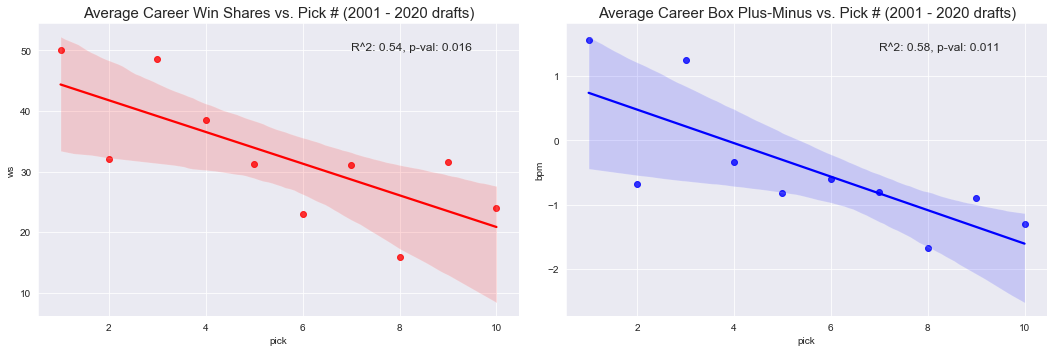

In [31]:
by_pick = draft_data.reset_index().groupby('pick').mean().reset_index()

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

ws_stats = stats.pearsonr(by_pick.pick,by_pick.ws)
sns.regplot(ax = axs[0], x='pick',y='ws',data=by_pick,color='red')
axs[0].set_title('Average Career Win Shares vs. Pick # (2001 - 2020 drafts)',fontsize=15)
axs[0].text(7,50,'R^2: ' + str((ws_stats[0]**2).round(2)) + ', p-val: ' + str(ws_stats[1].round(3)), fontsize=12)

bpm_stats = stats.pearsonr(by_pick.pick,by_pick.bpm)
sns.regplot(ax = axs[1], x='pick',y='bpm',data=by_pick, color = 'blue')
axs[1].set_title('Average Career Box Plus-Minus vs. Pick # (2001 - 2020 drafts)',fontsize=15)
axs[1].text(7,1.4,'R^2: ' + str((bpm_stats[0]**2).round(2)) + ', p-val: ' + str(bpm_stats[1].round(3)), fontsize=12)

plt.tight_layout()

plt.savefig('scatterplots.png')

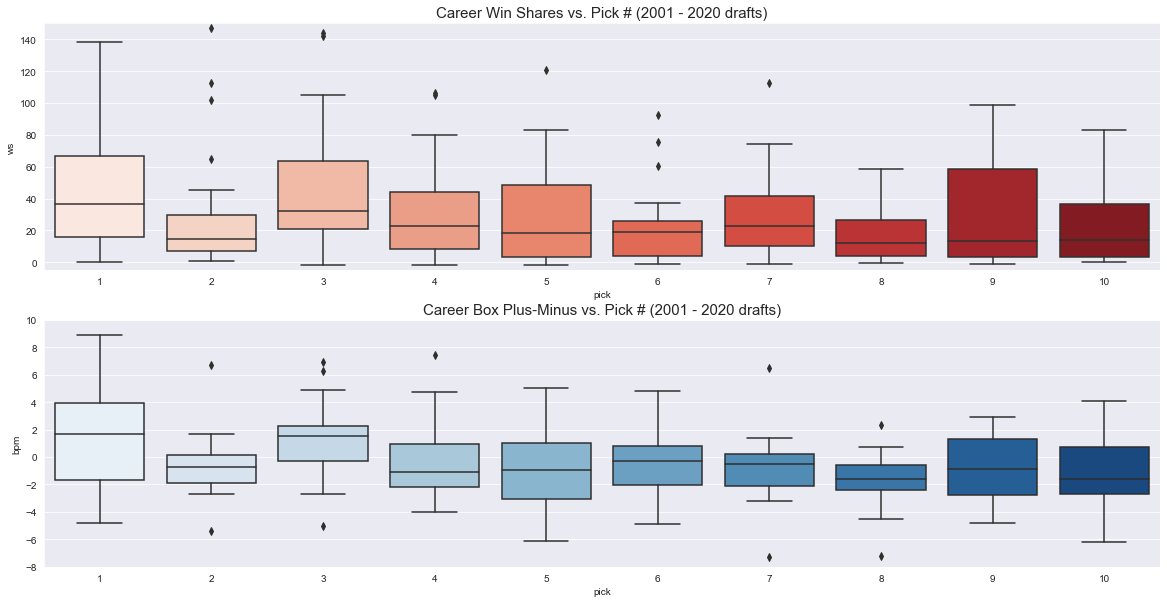

In [32]:
fig, axs = plt.subplots(2, 1, figsize=(20, 10))

sns.boxplot(ax = axs[0], x='pick',y='ws',data=draft_data.reset_index(),palette='Reds')
axs[0].set_ylim(-5,150)
axs[0].set_title('Career Win Shares vs. Pick # (2001 - 2020 drafts)',fontsize=15)

sns.boxplot(ax = axs[1], x='pick',y='bpm',data=draft_data.reset_index(),palette='Blues')
axs[1].set_ylim(-8,10)
axs[1].set_title('Career Box Plus-Minus vs. Pick # (2001 - 2020 drafts)',fontsize=15)

plt.savefig('boxplots.png')

### Analysis 6: Are there differences in the rookie median minutes per game between positions among the top 6 drafting teams?

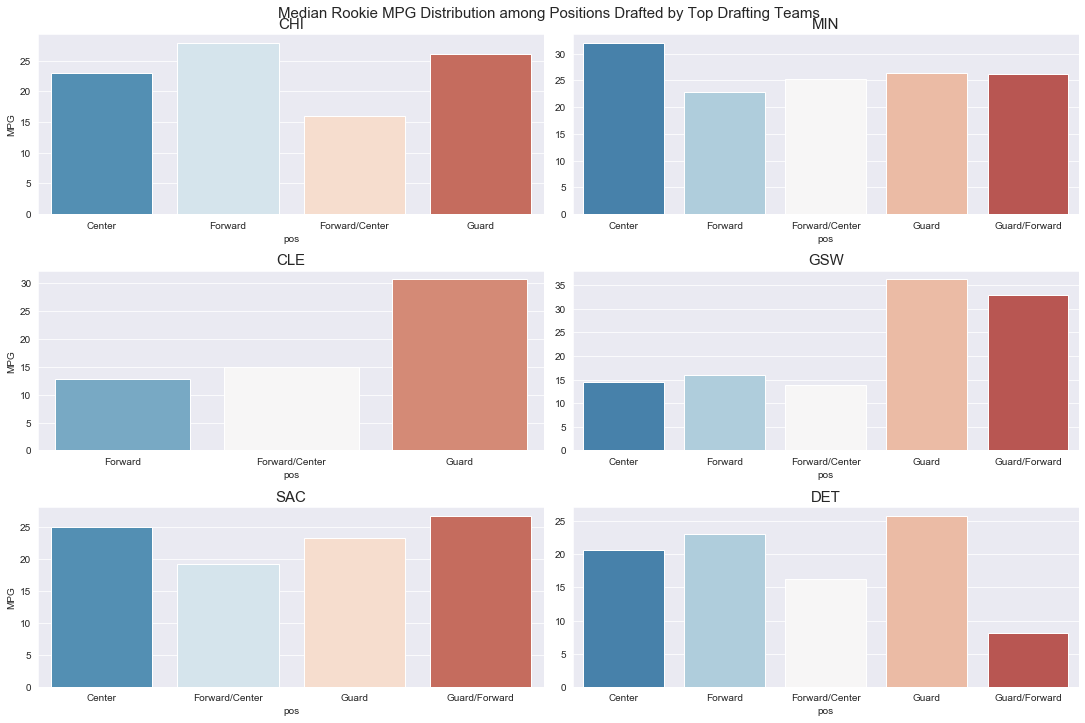

In [33]:
most_picks_teams = np.array(most_top10_picks.index)

fig, axs = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle('Median Rookie MPG Distribution among Positions Drafted by Top Drafting Teams', x=0.5, y=1, fontsize=15)

ax_list = [axs[0,0],axs[0,1],axs[1,0],axs[1,1],axs[2,0],axs[2,1]]

for i in range(6):
    
    data = draft_data[draft_data.team_id == most_picks_teams[i]].groupby('pos').median().mp_per_g
    sns.barplot(ax = ax_list[i], x = data.index, y = data.values, palette='RdBu_r')
    ax_list[i].set_title(most_picks_teams[i],fontsize=15)
   
plt.tight_layout()
plt.setp(axs[:,0],ylabel = 'MPG')

plt.savefig('barplot_grid.png')